<a href="https://colab.research.google.com/github/Jin407/USD-JPY-Trading-bot/blob/main/Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from oanda_backtest import Backtest
import matplotlib.pyplot as plt

bt = Backtest(access_token='142098975de581c4d4fd82391b3687fd-213e071d12eae303508d56a6ffb4d909', environment='practice')
filepath='usd-jpy-h4.csv'
if bt.exists(filepath):
    print("Loading data from CSV...")
    bt.read_csv(filepath)
else:
    params = {
        "granularity": "H4",  # 1 hour candlesticks (default=S5)
        "count": 5000 # 5000 candlesticks (default=500, maximum=5000)
    }
    bt.candles("USD_JPY", params)
    bt.to_csv(filepath)

bt.df['MA'] = bt.df['C'].rolling(window=20).mean()
bt.df['STD'] = bt.df['C'].rolling(window=20).std()
bt.df['UpperBand'] = bt.df['MA'] + (2 * bt.df['STD'])
bt.df['LowerBand'] = bt.df['MA'] - (2 * bt.df['STD'])
macd_line, signal_line= bt.macd(fast_period=12, slow_period=26, signal_period=9)


price_at_lower_band = bt.df['C'] <= bt.df['LowerBand']

price_at_higher_band = bt.df['C'] >= bt.df['UpperBand']

# MACD bearish crossover (MACD crosses below signal line)
macd_bearish_cross = (
    (macd_line < signal_line) &
    (macd_line.shift(1) >= signal_line.shift(1))
)

# MACD bullish crossover (MACD crosses above signal line)
macd_bullish_cross = (
    (macd_line > signal_line) &
    (macd_line.shift(1) <= signal_line.shift(1))
)

macd_zero_cross_below = (
    (macd_line < 0) &
    (macd_line.shift(1) >= 0)
)

bt.df['BB_width'] = bt.df['UpperBand'] - bt.df['LowerBand']
squeeze_threshold = 0.9
bt.df['BB_squeeze'] = bt.df['BB_width'] < squeeze_threshold

macd_zero_cross_above = (
    (macd_line > 0) &
    (macd_line.shift(1) <= 0)
)

# Buy entry condition
bt.buy_entry = macd_zero_cross_above & bt.df['BB_squeeze']

# sell entry condition
bt.sell_entry = macd_zero_cross_below & bt.df['BB_squeeze']

# Bollinger condition
bt.buy_exit =  price_at_higher_band | macd_bearish_cross

# Bollinger condition
bt.sell_exit = price_at_lower_band | macd_bullish_cross

bt.initial_deposit = 20000 # default=0
bt.units = 10000 # currency unit (default=10000)
bt.stop_loss = 100 # stop loss pips (default=0)
bt.take_profit = 150 # take profit pips (default=0)

bt.run()


,0
total profit,26550.000
total trades,6.000
win rate,83.333
profit factor,61.341
maximum drawdown,440.000
recovery factor,60.341
riskreward ratio,12.268
sharpe ratio,1.206
average return,2941.895
stop loss,0.000


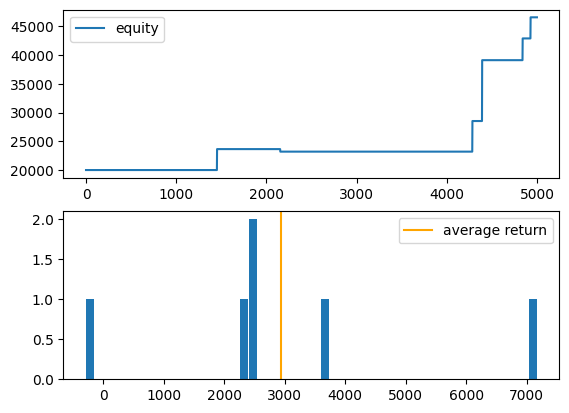

In [5]:
bt.plot()